## Bedroom:


=== Spectral Slope α in Bedroom Scenes ===
Real      Mean: 0.43830
GAN       Mean: 0.71278
Diffusion Mean: 0.69830
p-value Real vs GAN: 0.000e+00
p-value Real vs Diff: 1.149e-320
p-value GAN vs Diff: 1.082e-03


/var/folders/hf/2qw6xpcx1b51ntgj8ss0d90r0000gn/T/ipykernel_78212/3640438333.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Label", y="Value", inner="box", cut=0, linewidth=1, palette=palette)


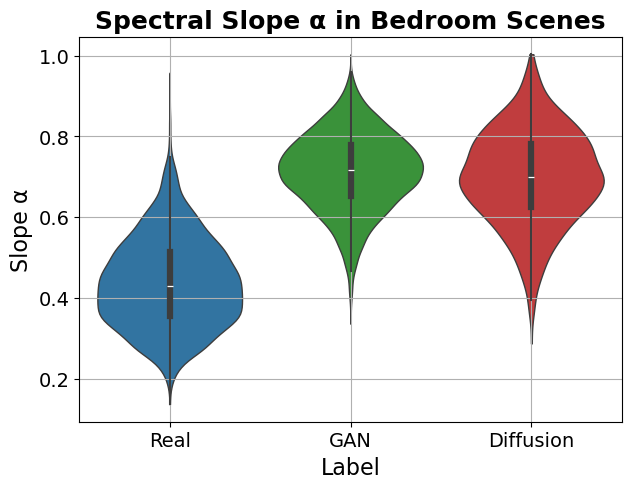


=== High-Frequency Energy Ratio in Bedroom Scenes ===
Real      Mean: 0.48889
GAN       Mean: 0.39302
Diffusion Mean: 0.40037
p-value Real vs GAN: 0.000e+00
p-value Real vs Diff: 7.156e-282
p-value GAN vs Diff: 1.786e-05


/var/folders/hf/2qw6xpcx1b51ntgj8ss0d90r0000gn/T/ipykernel_78212/3640438333.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Label", y="Value", inner="box", cut=0, linewidth=1, palette=palette)


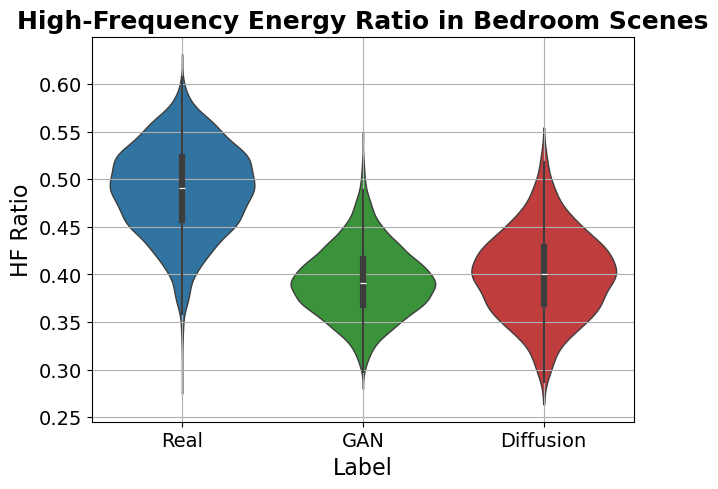

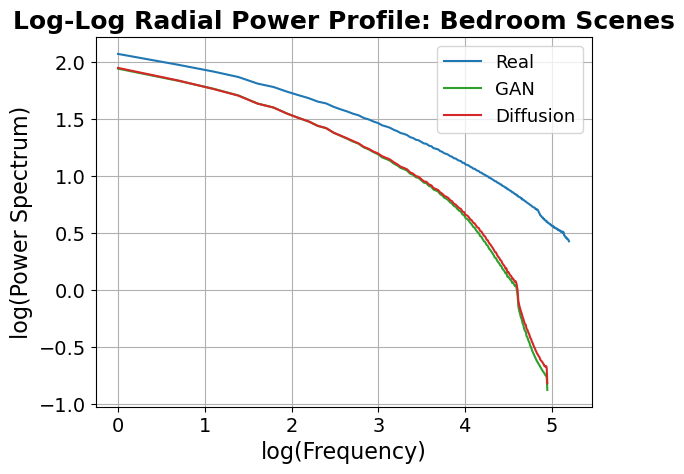

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress, ttest_ind
import seaborn as sns
import pandas as pd

plt.rcParams.update({
    "font.size": 16,         # Base font size
    "axes.titlesize": 18,    # Title font
    "axes.labelsize": 16,    # Axis label font
    "xtick.labelsize": 14,   # X tick labels
    "ytick.labelsize": 14,   # Y tick labels
    "legend.fontsize": 13,   # Legend font
    "figure.titlesize": 18   # Figure title font
})


def compute_fft_features(image, return_profile=False):
    """Compute FFT features: slope and high-frequency ratio"""
    H, W = image.shape

    if np.std(image) < 1e-6:
        return (np.nan, np.nan, None) if return_profile else (np.nan, np.nan)

    f_transform = np.fft.fft2(image)
    f_shifted = np.fft.fftshift(f_transform)
    log_magnitude = np.log1p(np.abs(f_shifted))

    y, x = np.indices((H, W))
    center = np.array([H // 2, W // 2])
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2).astype(np.int32)

    radial_sum = np.bincount(r.ravel(), weights=log_magnitude.ravel())
    radial_count = np.bincount(r.ravel())
    radial_profile = radial_sum / (radial_count + 1e-8)

    freqs = np.arange(1, len(radial_profile))
    power = radial_profile[1:]
    mask = power > 0

    if np.sum(mask) < 10:
        return (np.nan, np.nan, radial_profile) if return_profile else (np.nan, np.nan)

    log_freqs = np.log(freqs[mask])
    log_power = np.log(power[mask])

    if np.any(np.isnan(log_power)) or np.any(np.isinf(log_power)):
        return (np.nan, np.nan, radial_profile) if return_profile else (np.nan, np.nan)

    slope, _, _, _, _ = linregress(log_freqs, log_power)

    # High-frequency ratio (above 1/3rd of max frequency)
    cutoff = int(0.33 * len(power))
    hf_ratio = np.sum(power[cutoff:]) / (np.sum(power) + 1e-8)

    return (-slope, hf_ratio, radial_profile) if return_profile else (-slope, hf_ratio)

def process_fft_features(folder_path):
    slopes, ratios, profiles = [], [], []

    for file_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = img.astype(np.float32) / 255.0
        slope, hf_ratio, profile = compute_fft_features(img, return_profile=True)
        slopes.append(slope)
        ratios.append(hf_ratio)
        if profile is not None:
            profiles.append(profile)

    return slopes, ratios, profiles

def summarize_features(real, gan, diff, title, ylabel, filename_suffix):
    real = np.array(real)[~np.isnan(real)]
    gan = np.array(gan)[~np.isnan(gan)]
    diff = np.array(diff)[~np.isnan(diff)]

    real_mean, gan_mean, diff_mean = np.mean(real), np.mean(gan), np.mean(diff)

    print(f"\n=== {title} ===")
    print(f"Real      Mean: {real_mean:.5f}")
    print(f"GAN       Mean: {gan_mean:.5f}")
    print(f"Diffusion Mean: {diff_mean:.5f}")

    _, p_rg = ttest_ind(real, gan, equal_var=False)
    _, p_rd = ttest_ind(real, diff, equal_var=False)
    _, p_gd = ttest_ind(gan, diff, equal_var=False)
    print(f"p-value Real vs GAN: {p_rg:.3e}")
    print(f"p-value Real vs Diff: {p_rd:.3e}")
    print(f"p-value GAN vs Diff: {p_gd:.3e}")

    # Build dataframe for seaborn
    df = pd.DataFrame({
        "Value": np.concatenate([real, gan, diff]),
        "Label": (["Real"] * len(real)) + (["GAN"] * len(gan)) + (["Diffusion"] * len(diff))
    })

    # Custom color palette for violinplot
    palette = {'Real': 'tab:blue', 'GAN': 'tab:green', 'Diffusion': 'tab:red'}

    plt.figure(figsize=(7, 5))
    sns.violinplot(data=df, x="Label", y="Value", inner="box", cut=0, linewidth=1, palette=palette)
    plt.title(title, fontweight='bold')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.savefig(f"{filename_suffix}_violin.pdf")
    plt.show()

def plot_average_radial_profiles(profiles_dict, title):
    plt.figure()
    color_dict = {"Real": 'tab:blue', "GAN": 'tab:green', "Diffusion": 'tab:red'}
    for label, profiles in profiles_dict.items():
        min_len = min(len(p) for p in profiles)
        trimmed = [p[:min_len] for p in profiles]
        mean_profile = np.mean(trimmed, axis=0)
        freqs = np.arange(1, len(mean_profile))
        plt.plot(np.log(freqs), np.log(mean_profile[1:]), label=label, color=color_dict[label])

    plt.xlabel("log(Frequency)")
    plt.ylabel("log(Power Spectrum)")
    plt.title(f"Log-Log Radial Power Profile: {title}", fontweight='bold')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{title.replace(' ', '_')}_Radial_Profile.pdf")
    plt.show()

# Replace with your actual paths
real_images_path = '../data/BEST/bedroom/real'
gan_images_path = '../data/BEST/bedroom/gansformer'
diffusion_images_path = '../data/BEST/bedroom/ddpm'

# Step 1: Extract FFT features and radial profiles
real_slope, real_hf, real_profiles = process_fft_features(real_images_path)
gan_slope, gan_hf, gan_profiles = process_fft_features(gan_images_path)
diff_slope, diff_hf, diff_profiles = process_fft_features(diffusion_images_path)

# Step 2: Compare spectral slope (α)
summarize_features(
    real_slope, gan_slope, diff_slope,
    title="Spectral Slope α in Bedroom Scenes",
    ylabel="Slope α",
    filename_suffix="fft_slope_bedroom"
)

# Step 3: Compare High-Frequency Ratio
summarize_features(
    real_hf, gan_hf, diff_hf,
    title="High-Frequency Energy Ratio in Bedroom Scenes",
    ylabel="HF Ratio",
    filename_suffix="fft_hf_ratio_bedroom"
)

# Step 4: Plot average radial decay curves (log-log)
plot_average_radial_profiles({
    "Real": real_profiles,
    "GAN": gan_profiles,
    "Diffusion": diff_profiles
}, title="Bedroom Scenes")

## Face


=== Spectral Slope α in Face Images ===
Real      Mean: 0.56416
GAN       Mean: 0.62327
Diffusion Mean: 0.78313
p-value Real vs GAN: 0.000e+00
p-value Real vs Diff: 0.000e+00
p-value GAN vs Diff: 0.000e+00


/var/folders/hf/2qw6xpcx1b51ntgj8ss0d90r0000gn/T/ipykernel_78212/3640438333.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Label", y="Value", inner="box", cut=0, linewidth=1, palette=palette)


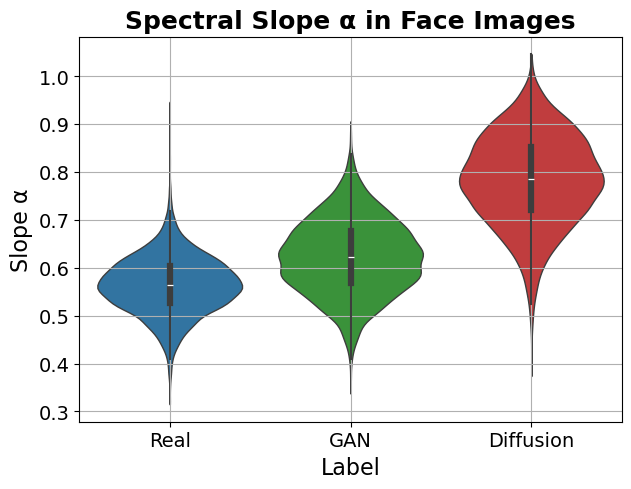


=== High-Frequency Energy Ratio in Face Images ===
Real      Mean: 0.44532
GAN       Mean: 0.42375
Diffusion Mean: 0.36848
p-value Real vs GAN: 0.000e+00
p-value Real vs Diff: 0.000e+00
p-value GAN vs Diff: 0.000e+00


/var/folders/hf/2qw6xpcx1b51ntgj8ss0d90r0000gn/T/ipykernel_78212/3640438333.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Label", y="Value", inner="box", cut=0, linewidth=1, palette=palette)


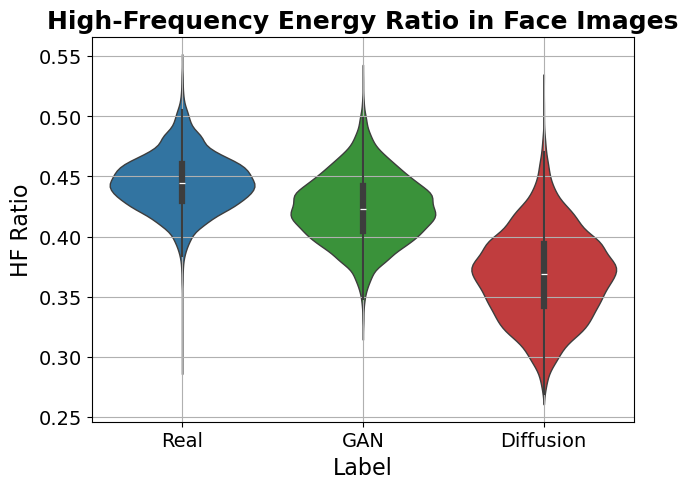

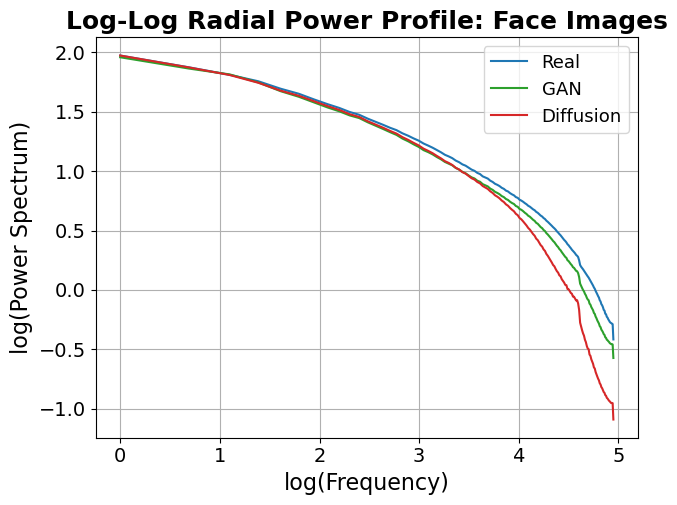

In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress, ttest_ind
import seaborn as sns
import pandas as pd

plt.rcParams.update({
    "font.size": 16,         # Base font size
    "axes.titlesize": 18,    # Title font
    "axes.labelsize": 16,    # Axis label font
    "xtick.labelsize": 14,   # X tick labels
    "ytick.labelsize": 14,   # Y tick labels
    "legend.fontsize": 13,   # Legend font
    "figure.titlesize": 18   # Figure title font
})

def compute_fft_features_imagenet(image):
    """Compute both slope and high-frequency ratio + profile"""
    H, W = image.shape
    if np.std(image) < 1e-6:
        return np.nan, np.nan, None

    f_transform = np.fft.fft2(image)
    f_shifted = np.fft.fftshift(f_transform)
    log_magnitude = np.log1p(np.abs(f_shifted))

    y, x = np.indices((H, W))
    center = np.array([H // 2, W // 2])
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2).astype(np.int32)

    radial_sum = np.bincount(r.ravel(), weights=log_magnitude.ravel())
    radial_count = np.bincount(r.ravel())
    radial_profile = radial_sum / (radial_count + 1e-8)

    freqs = np.arange(1, len(radial_profile))
    power = radial_profile[1:]
    mask = power > 0

    if np.sum(mask) < 10:
        return np.nan, np.nan, radial_profile

    log_freqs = np.log(freqs[mask])
    log_power = np.log(power[mask])
    if np.any(np.isnan(log_power)) or np.any(np.isinf(log_power)):
        return np.nan, np.nan, radial_profile

    slope, _, _, _, _ = linregress(log_freqs, log_power)
    cutoff = int(0.33 * len(power))
    hf_ratio = np.sum(power[cutoff:]) / (np.sum(power) + 1e-8)

    return -slope, hf_ratio, radial_profile

def process_fft_features_imagenet(folder_path):
    slopes, ratios, profiles = [], [], []

    for subdir, _, files in os.walk(folder_path):
        for file_name in files:
            if not (file_name.endswith(".jpg") or file_name.endswith(".png")):
                continue
            img_path = os.path.join(subdir, file_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = img.astype(np.float32) / 255.0
            slope, hf_ratio, profile = compute_fft_features_imagenet(img)
            slopes.append(slope)
            ratios.append(hf_ratio)
            if profile is not None:
                profiles.append(profile)

    return slopes, ratios, profiles

def summarize_features_violin_imagenet(real, gan, diff, title, ylabel, filename_suffix):
    real = np.array(real)[~np.isnan(real)]
    gan = np.array(gan)[~np.isnan(gan)]
    diff = np.array(diff)[~np.isnan(diff)]

    real_mean, gan_mean, diff_mean = np.mean(real), np.mean(gan), np.mean(diff)
    print(f"\n=== {title} ===")
    print(f"Real      Mean: {real_mean:.5f}")
    print(f"GAN       Mean: {gan_mean:.5f}")
    print(f"Diffusion Mean: {diff_mean:.5f}")

    from scipy.stats import ttest_ind
    _, p_rg = ttest_ind(real, gan, equal_var=False)
    _, p_rd = ttest_ind(real, diff, equal_var=False)
    _, p_gd = ttest_ind(gan, diff, equal_var=False)
    print(f"p-value Real vs GAN: {p_rg:.3e}")
    print(f"p-value Real vs Diff: {p_rd:.3e}")
    print(f"p-value GAN vs Diff: {p_gd:.3e}")

    df = pd.DataFrame({
        "Value": np.concatenate([real, gan, diff]),
        "Label": (["Real"] * len(real)) + (["GAN"] * len(gan)) + (["Diffusion"] * len(diff))
    })

    # Define the color palette (order matches Label order)
    palette = {'Real': 'tab:blue', 'GAN': 'tab:green', 'Diffusion': 'tab:red'}

    plt.figure(figsize=(7, 5))
    sns.violinplot(
        data=df, x="Label", y="Value",
        inner="box", cut=0, linewidth=1,
        palette=palette
    )
    plt.title(title, fontweight='bold')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.savefig(f"{filename_suffix}_violin.pdf")
    plt.show()

def plot_average_radial_profiles(profiles_dict, title):
    plt.figure(figsize=(7, 5.2))
    color_dict = {"Real": 'tab:blue', "GAN": 'tab:green', "Diffusion": 'tab:red'}
    for label, profiles in profiles_dict.items():
        min_len = min(len(p) for p in profiles)
        trimmed = [p[:min_len] for p in profiles]
        mean_profile = np.mean(trimmed, axis=0)
        freqs = np.arange(1, len(mean_profile))
        plt.plot(np.log(freqs), np.log(mean_profile[1:]), label=label, color=color_dict[label])

    plt.xlabel("log(Frequency)")
    plt.ylabel("log(Power Spectrum)")
    plt.title(f"Log-Log Radial Power Profile: {title}", fontweight='bold')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{title.replace(' ', '_')}_Radial_Profile.pdf")
    plt.show()

# Replace with your actual paths
real_images_path = '../data/BEST/face/real'
gan_images_path = '../data/BEST/face/stylegan2'
diffusion_images_path = '../data/BEST/face/palette'

# Step 1: Extract FFT features and radial profiles
real_slope, real_hf, real_profiles = process_fft_features(real_images_path)
gan_slope, gan_hf, gan_profiles = process_fft_features(gan_images_path)
diff_slope, diff_hf, diff_profiles = process_fft_features(diffusion_images_path)

# Step 2: Compare spectral slope (α)
summarize_features(
    real_slope, gan_slope, diff_slope,
    title="Spectral Slope α in Face Images",
    ylabel="Slope α",
    filename_suffix="fft_slope_face"
)

# Step 3: Compare High-Frequency Ratio
summarize_features(
    real_hf, gan_hf, diff_hf,
    title="High-Frequency Energy Ratio in Face Images",
    ylabel="HF Ratio",
    filename_suffix="fft_hf_ratio_face"
)

# Step 4: Plot average radial decay curves (log-log)
plot_average_radial_profiles({
    "Real": real_profiles,
    "GAN": gan_profiles,
    "Diffusion": diff_profiles
}, title="Face Images")

## ImageNet:


=== Spectral Slope α in ImageNet ===
Real      Mean: 0.50081
GAN       Mean: 0.89478
Diffusion Mean: 0.61065
p-value Real vs GAN: 0.000e+00
p-value Real vs Diff: 0.000e+00
p-value GAN vs Diff: 0.000e+00


/var/folders/hf/2qw6xpcx1b51ntgj8ss0d90r0000gn/T/ipykernel_78212/1520847537.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


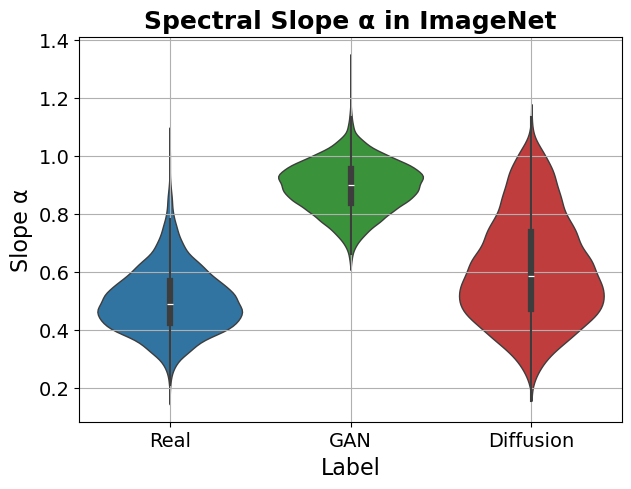


=== High-Frequency Energy Ratio in ImageNet ===
Real      Mean: 0.47459
GAN       Mean: 0.31818
Diffusion Mean: 0.43402
p-value Real vs GAN: 0.000e+00
p-value Real vs Diff: 0.000e+00
p-value GAN vs Diff: 0.000e+00


/var/folders/hf/2qw6xpcx1b51ntgj8ss0d90r0000gn/T/ipykernel_78212/1520847537.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


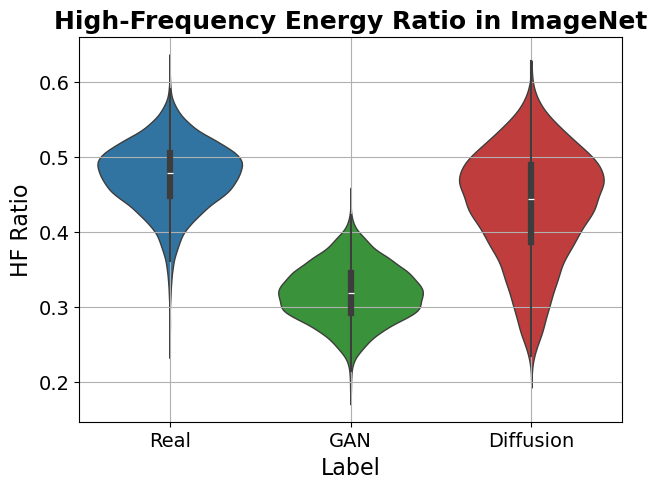

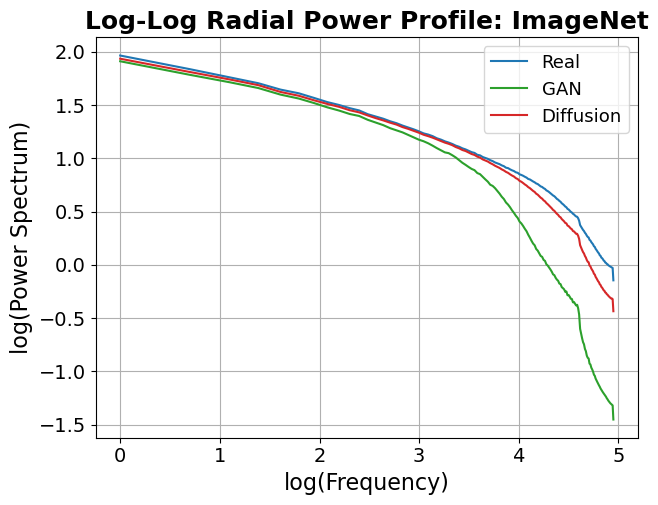

In [5]:
import seaborn as sns
import pandas as pd
import cv2
import numpy as np
import os
from scipy.stats import linregress
import matplotlib.pyplot as plt
import warnings
import logging
import sys

plt.rcParams.update({
    "font.size": 16,         # Base font size
    "axes.titlesize": 18,    # Title font
    "axes.labelsize": 16,    # Axis label font
    "xtick.labelsize": 14,   # X tick labels
    "ytick.labelsize": 14,   # Y tick labels
    "legend.fontsize": 13,   # Legend font
    "figure.titlesize": 18   # Figure title font
})

def compute_fft_features_imagenet(image):
    """Compute both slope and high-frequency ratio + profile"""
    H, W = image.shape
    if np.std(image) < 1e-6:
        return np.nan, np.nan, None

    f_transform = np.fft.fft2(image)
    f_shifted = np.fft.fftshift(f_transform)
    log_magnitude = np.log1p(np.abs(f_shifted))

    y, x = np.indices((H, W))
    center = np.array([H // 2, W // 2])
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2).astype(np.int32)

    radial_sum = np.bincount(r.ravel(), weights=log_magnitude.ravel())
    radial_count = np.bincount(r.ravel())
    radial_profile = radial_sum / (radial_count + 1e-8)

    freqs = np.arange(1, len(radial_profile))
    power = radial_profile[1:]
    mask = power > 0

    if np.sum(mask) < 10:
        return np.nan, np.nan, radial_profile

    log_freqs = np.log(freqs[mask])
    log_power = np.log(power[mask])
    if np.any(np.isnan(log_power)) or np.any(np.isinf(log_power)):
        return np.nan, np.nan, radial_profile

    slope, _, _, _, _ = linregress(log_freqs, log_power)
    cutoff = int(0.33 * len(power))
    hf_ratio = np.sum(power[cutoff:]) / (np.sum(power) + 1e-8)

    return -slope, hf_ratio, radial_profile

def process_fft_features_imagenet(folder_path):
    slopes, ratios, profiles = [], [], []

    for subdir, _, files in os.walk(folder_path):
        for file_name in files:
            if not (file_name.endswith(".jpg") or file_name.endswith(".png")):
                continue
            img_path = os.path.join(subdir, file_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = img.astype(np.float32) / 255.0
            slope, hf_ratio, profile = compute_fft_features_imagenet(img)
            slopes.append(slope)
            ratios.append(hf_ratio)
            if profile is not None:
                profiles.append(profile)

    return slopes, ratios, profiles

def summarize_features_violin_imagenet(real, gan, diff, title, ylabel, filename_suffix):
    real = np.array(real)[~np.isnan(real)]
    gan = np.array(gan)[~np.isnan(gan)]
    diff = np.array(diff)[~np.isnan(diff)]

    real_mean, gan_mean, diff_mean = np.mean(real), np.mean(gan), np.mean(diff)
    print(f"\n=== {title} ===")
    print(f"Real      Mean: {real_mean:.5f}")
    print(f"GAN       Mean: {gan_mean:.5f}")
    print(f"Diffusion Mean: {diff_mean:.5f}")

    from scipy.stats import ttest_ind
    _, p_rg = ttest_ind(real, gan, equal_var=False)
    _, p_rd = ttest_ind(real, diff, equal_var=False)
    _, p_gd = ttest_ind(gan, diff, equal_var=False)
    print(f"p-value Real vs GAN: {p_rg:.3e}")
    print(f"p-value Real vs Diff: {p_rd:.3e}")
    print(f"p-value GAN vs Diff: {p_gd:.3e}")

    df = pd.DataFrame({
        "Value": np.concatenate([real, gan, diff]),
        "Label": (["Real"] * len(real)) + (["GAN"] * len(gan)) + (["Diffusion"] * len(diff))
    })

    # Define the color palette (order matches Label order)
    palette = {'Real': 'tab:blue', 'GAN': 'tab:green', 'Diffusion': 'tab:red'}

    plt.figure(figsize=(7, 5))
    sns.violinplot(
        data=df, x="Label", y="Value",
        inner="box", cut=0, linewidth=1,
        palette=palette
    )
    plt.title(title, fontweight='bold')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.savefig(f"{filename_suffix}_violin.pdf")
    plt.show()

def plot_average_radial_profiles(profiles_dict, title):
    plt.figure(figsize=(7, 5.2))
    color_dict = {"Real": 'tab:blue', "GAN": 'tab:green', "Diffusion": 'tab:red'}
    for label, profiles in profiles_dict.items():
        min_len = min(len(p) for p in profiles)
        trimmed = [p[:min_len] for p in profiles]
        mean_profile = np.mean(trimmed, axis=0)
        freqs = np.arange(1, len(mean_profile))
        plt.plot(np.log(freqs), np.log(mean_profile[1:]), label=label, color=color_dict[label])

    plt.xlabel("log(Frequency)")
    plt.ylabel("log(Power Spectrum)")
    plt.title(f"Log-Log Radial Power Profile: {title}", fontweight='bold')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{title.replace(' ', '_')}_Radial_Profile.pdf")
    plt.show()


# ========== Example Usage for ImageNet ==========

real_path = '../data/BEST/imagenet/real_imagenet'
gan_path = '../data/BEST/imagenet/big_gan'
diff_path = '../data/BEST/imagenet/vq_diffusion'

# Extract features
real_slope, real_hf, real_profiles = process_fft_features_imagenet(real_path)
gan_slope, gan_hf, gan_profiles = process_fft_features_imagenet(gan_path)
diff_slope, diff_hf, diff_profiles = process_fft_features_imagenet(diff_path)

# Plot slope violin plot
summarize_features_violin_imagenet(
    real_slope, gan_slope, diff_slope,
    title="Spectral Slope α in ImageNet",
    ylabel="Slope α",
    filename_suffix="imagenet_fft_slope"
)

# Plot HF ratio violin plot
summarize_features_violin_imagenet(
    real_hf, gan_hf, diff_hf,
    title="High-Frequency Energy Ratio in ImageNet",
    ylabel="HF Ratio",
    filename_suffix="imagenet_fft_hf_ratio"
)

# Plot log-log radial profile curves
plot_average_radial_profiles({
    "Real": real_profiles,
    "GAN": gan_profiles,
    "Diffusion": diff_profiles
}, title="ImageNet")

## Qualitative Results

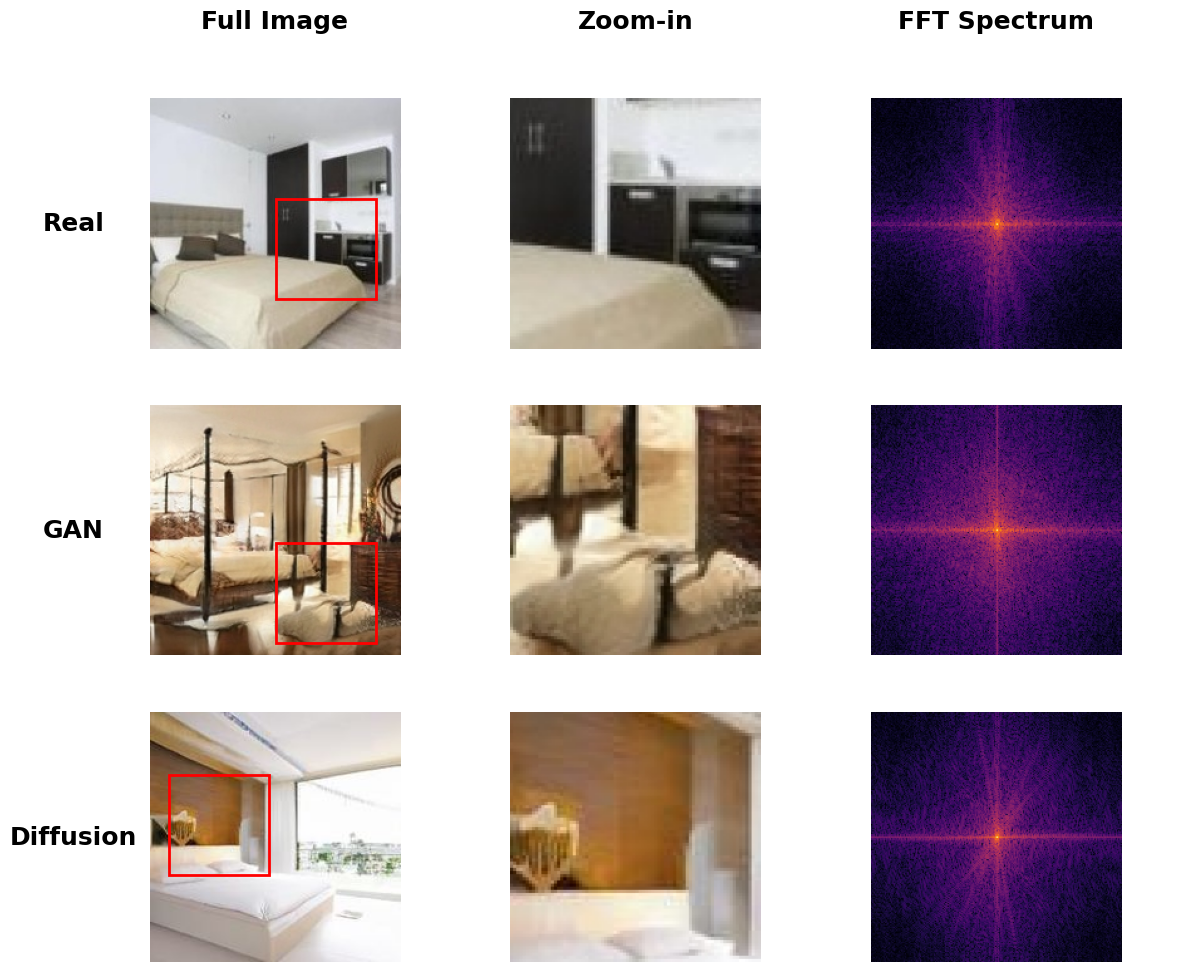

In [20]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cv2
import numpy as np
from numpy.fft import fft2, fftshift

def plot_fft_grid_clean_compact(image_paths, labels, zoom_boxes, zoom_scale=2, save_path=None):
    """
    Improved compact layout for comparing real, GAN, and diffusion images:
    - Top row: column headers
    - Left column: row labels (Real, GAN, Diffusion)
    - Grid content: full image + zoom-in + FFT
    """
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(
        nrows=4, ncols=5,
        width_ratios=[0.08, 1, 1, 1, 1],
        height_ratios=[0.0001, 1, 1, 1],
        hspace=0.3
    )
    ax_titles = ["Full Image", "Zoom-in", "FFT Spectrum"]

    # Top row titles
    for i, title in enumerate(ax_titles):
        ax = fig.add_subplot(gs[0, i + 1])
        ax.set_title(title, fontsize=18, weight='bold', pad=10)
        ax.axis("off")

    for row, (image_path, label, zoom_box) in enumerate(zip(image_paths, labels, zoom_boxes)):
        img_color = cv2.imread(image_path)
        if img_color is None:
            raise ValueError(f"Could not load image: {image_path}")
        img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)

        img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0
        F = fftshift(fft2(img_gray))
        log_mag = np.log1p(np.abs(F))
        log_mag -= log_mag.min()
        log_mag /= log_mag.max() + 1e-8

        x, y, zoom_w, zoom_h = zoom_box
        zoom_crop = img_color[y:y+zoom_h, x:x+zoom_w]
        zoom_resized = cv2.resize(zoom_crop, (zoom_w * zoom_scale, zoom_h * zoom_scale), interpolation=cv2.INTER_NEAREST)

        # Left label
        ax_label = fig.add_subplot(gs[row + 1, 0])
        ax_label.text(0.5, 0.5, label, va='center', ha='center', fontsize=18, weight='bold')
        ax_label.axis("off")

        # Full image
        ax0 = fig.add_subplot(gs[row + 1, 1])
        ax0.imshow(img_color)
        ax0.add_patch(plt.Rectangle((x, y), zoom_w, zoom_h, edgecolor='red', facecolor='none', lw=2))
        ax0.axis("off")

        # Zoom-in
        ax1 = fig.add_subplot(gs[row + 1, 2])
        ax1.imshow(zoom_resized)
        ax1.axis("off")

        # FFT
        ax2 = fig.add_subplot(gs[row + 1, 3])
        ax2.imshow(log_mag, cmap='inferno')
        ax2.axis("off")

    plt.subplots_adjust(left=0.01, right=0.99, top=0.96, bottom=0.04, wspace=0.05, hspace=0.08)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_fft_grid_clean_compact(
    image_paths=[
        "../data/BEST/bedroom/real_200x200/1fea2d32fdc6ca9472b1c094a6125fe511fb5254.jpg",
        "../data/BEST/bedroom/gansformer/img004794.jpg",
        "../data/BEST/bedroom/ddpm/img000250.jpg"
    ],
    labels=["Real", "GAN", "Diffusion"],
    zoom_boxes=[
        (100, 80, 80, 80),    # Real
        (100, 110, 80, 80),   # GAN
        (15, 50, 80, 80)       # Diffusion
    ],
    save_path="fft_comparison_bedroom.pdf"
)

#"../data/BEST/bedroom/ddpm/img000723.jpg"

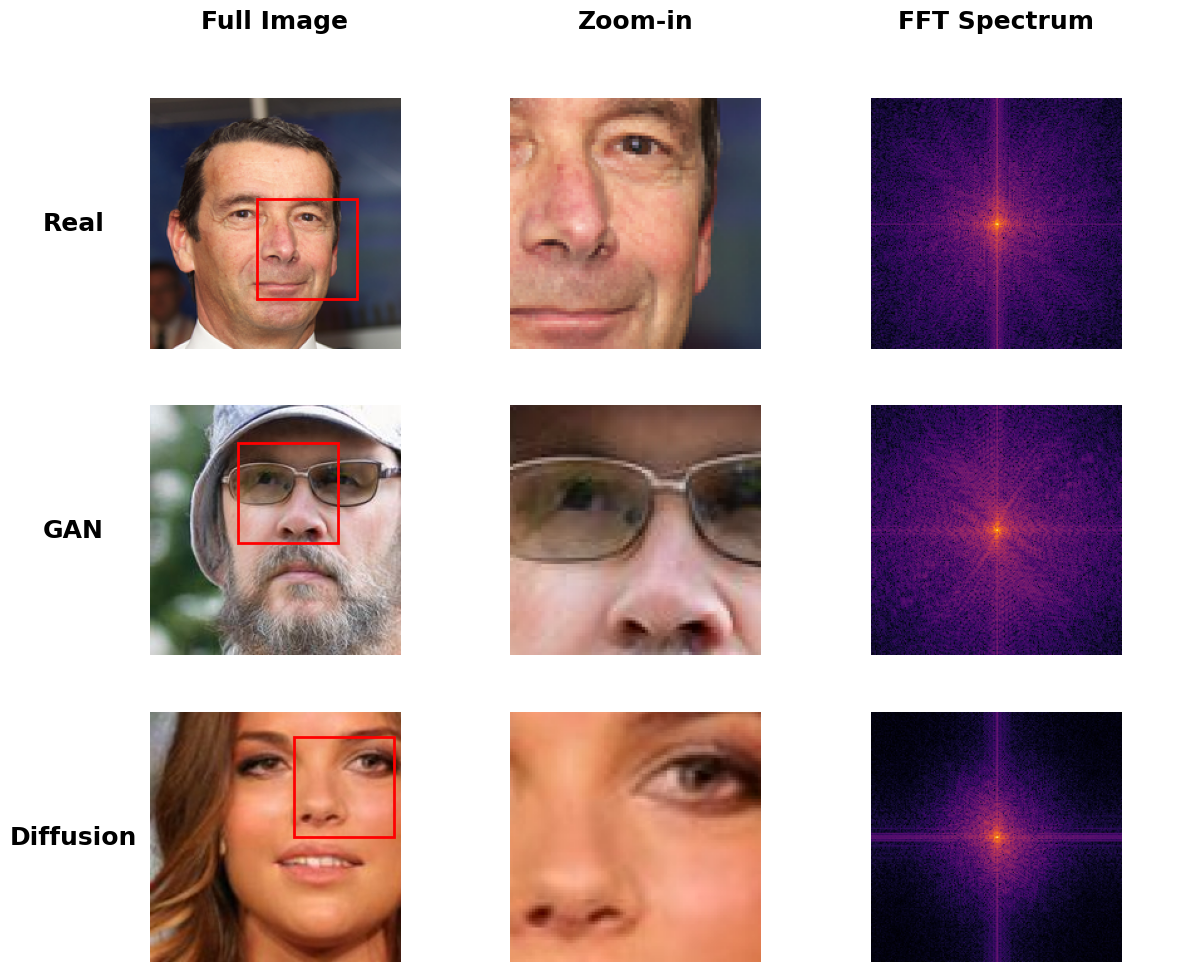

In [14]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cv2
import numpy as np
from numpy.fft import fft2, fftshift

def plot_fft_grid_clean_compact(image_paths, labels, zoom_boxes, zoom_scale=2, save_path=None):
    """
    Improved compact layout for comparing real, GAN, and diffusion images:
    - Top row: column headers
    - Left column: row labels (Real, GAN, Diffusion)
    - Grid content: full image + zoom-in + FFT
    """
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(
        nrows=4, ncols=5,
        width_ratios=[0.08, 1, 1, 1, 1],
        height_ratios=[0.0001, 1, 1, 1],
        hspace=0.3
    )
    ax_titles = ["Full Image", "Zoom-in", "FFT Spectrum"]

    # Top row titles
    for i, title in enumerate(ax_titles):
        ax = fig.add_subplot(gs[0, i + 1])
        ax.set_title(title, fontsize=18, weight='bold', pad=10)
        ax.axis("off")

    for row, (image_path, label, zoom_box) in enumerate(zip(image_paths, labels, zoom_boxes)):
        img_color = cv2.imread(image_path)
        if img_color is None:
            raise ValueError(f"Could not load image: {image_path}")
        img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)

        img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0
        F = fftshift(fft2(img_gray))
        log_mag = np.log1p(np.abs(F))
        log_mag -= log_mag.min()
        log_mag /= log_mag.max() + 1e-8

        x, y, zoom_w, zoom_h = zoom_box
        zoom_crop = img_color[y:y+zoom_h, x:x+zoom_w]
        zoom_resized = cv2.resize(zoom_crop, (zoom_w * zoom_scale, zoom_h * zoom_scale), interpolation=cv2.INTER_NEAREST)

        # Left label
        ax_label = fig.add_subplot(gs[row + 1, 0])
        ax_label.text(0.5, 0.5, label, va='center', ha='center', fontsize=18, weight='bold')
        ax_label.axis("off")

        # Full image
        ax0 = fig.add_subplot(gs[row + 1, 1])
        ax0.imshow(img_color)
        ax0.add_patch(plt.Rectangle((x, y), zoom_w, zoom_h, edgecolor='red', facecolor='none', lw=2))
        ax0.axis("off")

        # Zoom-in
        ax1 = fig.add_subplot(gs[row + 1, 2])
        ax1.imshow(zoom_resized)
        ax1.axis("off")

        # FFT
        ax2 = fig.add_subplot(gs[row + 1, 3])
        ax2.imshow(log_mag, cmap='inferno')
        ax2.axis("off")

    plt.subplots_adjust(left=0.01, right=0.99, top=0.96, bottom=0.04, wspace=0.05, hspace=0.08)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_fft_grid_clean_compact(
    image_paths=[
        "../data/BEST/face/real/01109.png",
        "../data/BEST/face/stylegan2/img066779.jpg",
        "../data/BEST/face/palette/img000006.jpg"
    ],
    labels=["Real", "GAN", "Diffusion"],
    zoom_boxes=[
        (85, 80, 80, 80),    # Real
        (70, 30, 80, 80),   # GAN
        (115, 20, 80, 80)       # Diffusion
    ],
    save_path="fft_comparison_face.pdf"
)

#(80, 60, 80, 80)

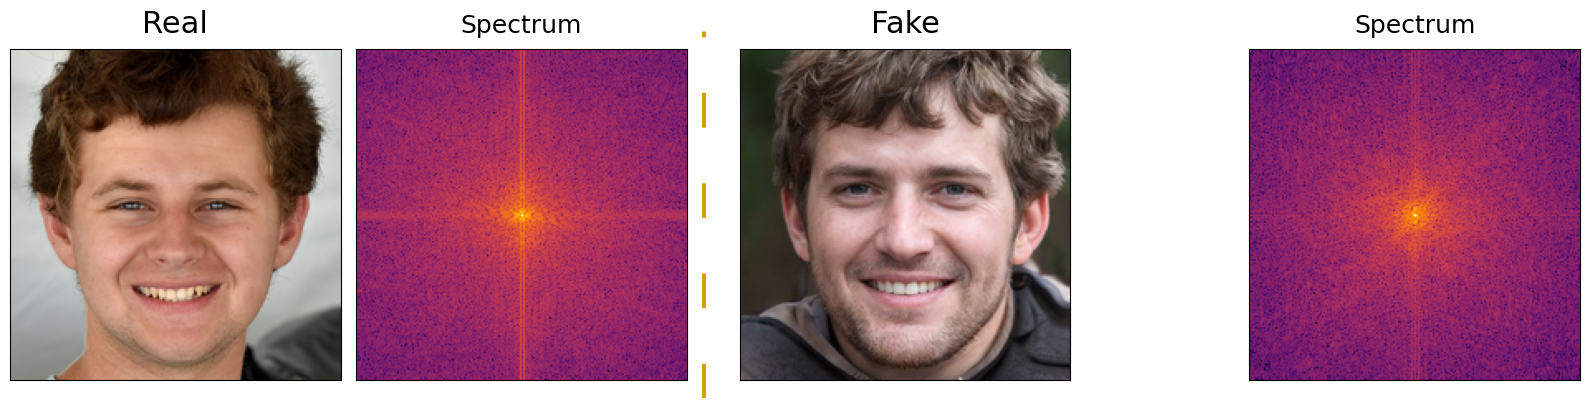

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft2, fftshift
import imageio.v2 as imageio
from matplotlib.patches import Rectangle, ConnectionPatch

# --- Load your images ---
real_img = imageio.imread('../data/BEST/face/real/01607.png')          # Replace with your path
fake_img = imageio.imread('../data/BEST/face/stylegan2/img099299.jpg')          # Replace with your path

def rgb2gray(img):
    if img.ndim == 3:
        return np.dot(img[..., :3], [0.299, 0.587, 0.114])
    return img

# --- FFT Spectrum Function ---
def get_spectrum(img):
    gray = rgb2gray(img)
    f = fftshift(fft2(gray))
    spectrum = np.log(1 + np.abs(f))
    # Normalize for display
    spectrum = (spectrum - spectrum.min()) / (spectrum.max() - spectrum.min())
    return spectrum

fig = plt.figure(figsize=(16, 4))
# width_ratios: [real, real spectrum, sep, fake, blank, fake spectrum]
gs = fig.add_gridspec(1, 6, width_ratios=[1, 1, 0.07, 1, 0.45, 1])

# --- Real image ---
ax_real = fig.add_subplot(gs[0, 0])
ax_real.imshow(real_img)
ax_real.set_xticks([]); ax_real.set_yticks([])
ax_real.set_title("Real", fontsize=22, pad=12)

# --- Real spectrum ---
ax_real_spec = fig.add_subplot(gs[0, 1])
ax_real_spec.imshow(get_spectrum(real_img), cmap='inferno')
ax_real_spec.set_xticks([]); ax_real_spec.set_yticks([])
ax_real_spec.set_title("Spectrum", fontsize=18, pad=12)

# --- Dashed line separator ---
ax_sep = fig.add_subplot(gs[0, 2])
ax_sep.axis('off')
ax_sep.plot([0, 0], [0, 1], linestyle=(0, (5, 8)), color='#D3A000', lw=5, transform=ax_sep.transAxes)

# --- Fake image ---
ax_fake = fig.add_subplot(gs[0, 3])
ax_fake.imshow(fake_img)
ax_fake.set_xticks([]); ax_fake.set_yticks([])
ax_fake.set_title("Fake", fontsize=22, pad=12)

# --- Blank axis for space ---
ax_blank = fig.add_subplot(gs[0, 4])
ax_blank.axis('off')

# --- Fake spectrum ---
ax_fake_spec = fig.add_subplot(gs[0, 5])
ax_fake_spec.imshow(get_spectrum(fake_img), cmap='inferno')
ax_fake_spec.set_xticks([]); ax_fake_spec.set_yticks([])
ax_fake_spec.set_title("Spectrum", fontsize=18, pad=12)

plt.tight_layout()
plt.show()